In [1]:
!pip install librosa

In [19]:
! pip install ffmpeg

  Preparing metadata (setup.py) ... done
  Created wheel for ffmpeg: filename=ffmpeg-1.4-py3-none-any.whl size=6082 sha256=fa6002a46716836718a6b3afcd709f26e59fcee09060b922b8a69f0756484277
  Stored in directory: /root/.cache/pip/wheels/56/30/c5/576bdd729f3bc062d62a551be7fefd6ed2f761901568171e4e
Successfully built ffmpeg


In [2]:
import numpy as np
import pandas as pd
import librosa

In [3]:

# Computing flux in the sliding window mechanism


def compute_flux_with_sliding_window(audio_path, window_size=5, n_fft=2048, hop_length=512, freq_cutoff=1000):

    duration = 60 # we take an assumtion that the intro lies in the first 60s

    y, sr = librosa.load(audio_path, sr=None, duration=duration)

    # stft computing
    D = librosa.stft(y, n_fft=n_fft, hop_length=hop_length)

    # magnitude spectrum with decibal value
    magnitude = np.abs(D)

    # the index of the frequency bin corresponding to the cutoff frequency where cutoff is 1000Hz
    freq_bins = np.fft.rfftfreq(n_fft, 1/sr)
    max_freq_index = np.where(freq_bins <= freq_cutoff)[0][-1]

    #  frequency cutoff from 0 to max frequency index ie 1000Hz to get rid of the high frequency noise
    magnitude = magnitude[:max_freq_index + 1, :]

    num_freq_bins, num_frames = magnitude.shape



# Spectral flux is a measure of how much the power spectrum of a signal changes between successive time frames


    # Compute the spectral flux
    flux = np.zeros(num_frames)
    for i in range(1, num_frames):
        diff = magnitude[:, i] - magnitude[:, i-1]
        flux[i] = np.sum(np.abs(diff))

    # Apply the sliding window technique
    flux_sliding = np.zeros_like(flux)
    for i in range(num_frames):
        start = max(0, i - window_size + 1)
        flux_sliding[i] = np.mean(flux[start : i+1])

    return flux_sliding

In [5]:

if __name__ == "__main__":
    audio_path = '/content/Trent Reznor & Atticus Ross - Challengers_ Match Point Challengers (Original Score).mp3'
    window_size = 5
    flux_sliding = compute_flux_with_sliding_window(audio_path, window_size)
    print("Smoothed Flux Values:", flux_sliding)


Smoothed Flux Values: [  0.           0.           0.         ... 169.43996582 157.47717896
 179.74360352]


In [6]:


# CALCULATING THE TIME AT WHICH WE GET THE HIT

import numpy as np

#  your flux array is flux_sliding
mean_val = np.mean(flux_sliding)
std_val = np.std(flux_sliding)

# Alpha controls how strict you want the threshold
# alpha is the hyperparam

alpha = 2
threshold = mean_val + alpha * std_val


# CURRENTLY EMPTY
frame_index_of_change = None



for i, value in enumerate(flux_sliding):
    if value > threshold:
        frame_index_of_change = i
        break



if frame_index_of_change is not None:
    print(f"First sudden change detected at frame {frame_index_of_change}")
else:
    print("No sudden change found above the threshold.")

First sudden change detected at frame 1344


In [7]:

# CONVERTING FRAME INDEX TO TIME

def find_sudden_change_time(flux_sliding, hop_length, sr, alpha=2.0):
    # 1. Define threshold
    mu = np.mean(flux_sliding)
    sigma = np.std(flux_sliding)
    threshold = mu + alpha * sigma # mu is mean  sigma is the std dev

    # 2. Find the first index above threshold
    for i, value in enumerate(flux_sliding):
        if value > threshold:
            # 3. Convert frame index to time in seconds
            return i * (hop_length / sr) # finds the corresponding time in seconds when the frames are div by the sampling rate


    # If no index exceeds the threshold
    return None



sr = librosa.get_samplerate('/content/Trent Reznor & Atticus Ross - Challengers_ Match Point Challengers (Original Score).mp3')


In [8]:

# Example usage:
time_of_change = find_sudden_change_time(flux_sliding, hop_length=512, sr=44100, alpha=2.0)
if time_of_change is not None:
    print(f"Sudden change detected at ~{time_of_change:.2f} seconds.")
else:
    print("No sudden change found above the threshold.")


# uf you want to visualise your spectogram

Sudden change detected at ~15.60 seconds.


## Things needed now


1. Input the file
2. take a function that takes the samlpe rate and then puts it out there
3.

# Flux visualisation

In [9]:
import matplotlib.pyplot as plt

def plot_flux(flux):
    plt.figure(figsize=(10, 4))
    plt.plot(flux, label='Spectral Flux')
    plt.title('Spectral Flux Over Time')
    plt.xlabel('Time Frame')
    plt.ylabel('Flux')
    plt.legend()
    plt.show()


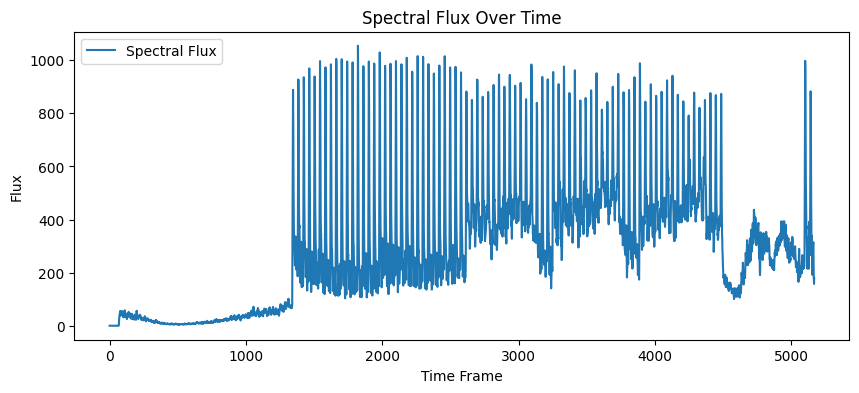

In [11]:
plot_flux(flux_sliding)

In [12]:

def flux_visualisation(flux_sliding):
    print("Do you want to visualise the flux y/n")
    ans = input()

    if ans == 'y':
        plot_flux(flux_sliding)

    else:
        print("Thank you")


    return None

Do you want to visualise the flux y/n
y


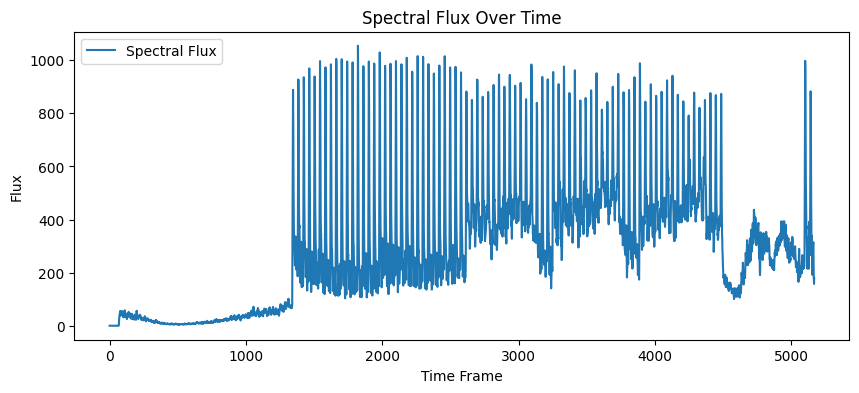

In [14]:
flux_visualisation(flux_sliding=flux_sliding)

In [21]:
import argparse
import numpy as np
import librosa
import matplotlib.pyplot as plt

def load_audio(audio_path, duration=60):
    try:
        y, sr = librosa.load(audio_path, sr=None, duration=duration)
        return y, sr
    except FileNotFoundError:
        print("Audio file not found. Please check the path.")
        exit()
    except Exception as e:
        print(f"Error loading audio file: {e}")
        exit()

def compute_stft(y, sr, n_fft=2048, hop_length=512, freq_cutoff=1000):
    D = librosa.stft(y, n_fft=n_fft, hop_length=hop_length) # hop length is the number of samples between successive frames
    magnitude = np.abs(D) # magnitude of the STFT
    freq_bins = np.fft.rfftfreq(n_fft, 1/sr) # frequency bins
    max_freq_index = np.where(freq_bins <= freq_cutoff)[0][-1]
    magnitude = magnitude[:max_freq_index + 1, :]
    return magnitude

def compute_flux(magnitude):
    num_frames = magnitude.shape[1] #
    flux = np.zeros(num_frames)
    for i in range(1, num_frames):
        diff = magnitude[:, i] - magnitude[:, i-1]
        flux[i] = np.sum(np.abs(diff))
    return flux

def apply_sliding_window(flux, window_size=5):
    num_frames = len(flux)
    flux_sliding = np.zeros_like(flux) # same empty array as flux
    for i in range(num_frames):
        start = max(0, i - window_size + 1)
        flux_sliding[i] = np.mean(flux[start : i+1]) # mean of the flux values in the window
    return flux_sliding

def find_sudden_change_time(flux_sliding, hop_length, sr, alpha=2.0):
    mean_val = np.mean(flux_sliding)
    std_val = np.std(flux_sliding)
    threshold = mean_val + alpha * std_val
# Alpha controls how strict you want the threshold
# alpha is the hyperparameter that you can tune to make the threshold more or less strict
    for i, value in enumerate(flux_sliding):
        if value > threshold:
            return i * (hop_length / sr)
    return None

def plot_flux(flux):
    plt.figure(figsize=(10, 4))
    plt.plot(flux, label='Spectral Flux')
    plt.title('Spectral Flux Over Time')
    plt.xlabel('Time Frame')
    plt.ylabel('Flux')
    plt.legend()
    plt.show()



def get_args():
    parser = argparse.ArgumentParser(description="Process some audio files.")
    parser.add_argument('audio_path', type=str, help='Path to the audio file')
    parser.add_argument('--window_size', type=int, default=5, help='Window size for the sliding window (Default 5)')
    parser.add_argument('--n_fft', type=int, default=2048, help='FFT window size ( Press enter to default value if not sure )')
    parser.add_argument('--hop_length', type=int, default=512, help='Hop length for STFT( Press enter to default value if not sure )')
    parser.add_argument('--freq_cutoff', type=int, default=1000, help='Frequency cutoff for noise reduction ( 1000 Hz is default )')

    parser.add_argument('--alpha', type=float, default=2.0, help='Alpha value for threshold calculation( Default 2.0 )')
    parser.add_argument('--visualize', action='store_true', help='Set this flag to visualize spectral flux')

    return parser.parse_args()



In [22]:


def main():
    args = get_args()
    print(f"Attempting to load audio from: {args.audio_path}")
    y, sr = load_audio(args.audio_path)
    magnitude = compute_stft(y, sr, args.n_fft, args.hop_length, args.freq_cutoff)
    flux = compute_flux(magnitude)
    flux_sliding = apply_sliding_window(flux, args.window_size)
    change_time = find_sudden_change_time(flux_sliding, args.hop_length, sr, args.alpha)

    if change_time is not None:
        print(f"Sudden change detected at ~{change_time:.2f} seconds.")
    else:
        print("No sudden change found above the threshold.")

    if args.visualize:
        plot_flux(flux_sliding)



if __name__ == "__main__":
    main()


usage: colab_kernel_launcher.py [-h] [--window_size WINDOW_SIZE] [--n_fft N_FFT]
                                [--hop_length HOP_LENGTH] [--freq_cutoff FREQ_CUTOFF]
                                [--alpha ALPHA] [--visualize]
                                audio_path
colab_kernel_launcher.py: error: unrecognized arguments: -f


SystemExit: 2

/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py:3561: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


Enter the path to the audio file: /content/Trent Reznor & Atticus Ross - Challengers_ Match Point Challengers (Original Score).mp3
Enter window size for the sliding window (default is 5): 
Enter FFT window size (default is 2048): 
Enter hop length for STFT (default is 512): 
Enter frequency cutoff for noise reduction (default is 1000 Hz): 
Enter alpha value for threshold calculation (default is 2.0): 
Do you want to visualize the spectral flux? (yes/no): yes
Attempting to load audio from: /content/Trent Reznor & Atticus Ross - Challengers_ Match Point Challengers (Original Score).mp3
Smoothed Flux Values: [  0.           0.           0.         ... 169.43996582 157.47717896
 179.74360352]
Sudden change detected at ~15.60 seconds.


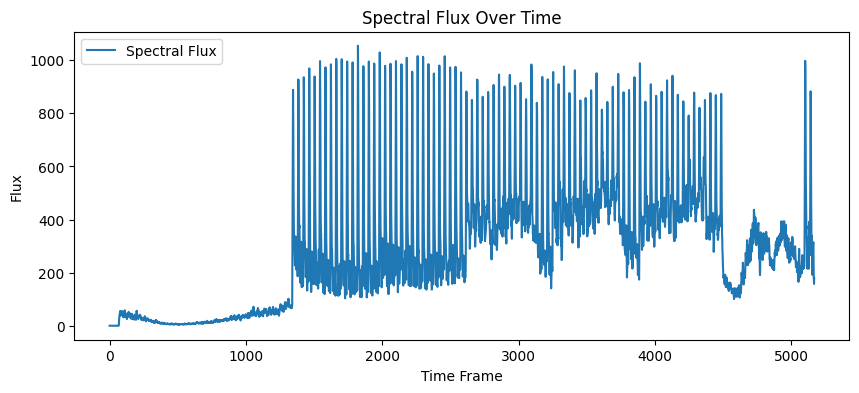

In [28]:
import numpy as np
import librosa
import matplotlib.pyplot as plt

def load_audio(audio_path, duration=60):
    try:
        y, sr = librosa.load(audio_path, sr=None, duration=duration)
        return y, sr
    except FileNotFoundError:
        print("Audio file not found. Please check the path.")
        exit()
    except Exception as e:
        print(f"Error loading audio file: {e}")
        exit()

def compute_stft(y, sr, n_fft=2048, hop_length=512, freq_cutoff=1000):
    D = librosa.stft(y, n_fft=n_fft, hop_length=hop_length)
    magnitude = np.abs(D)
    freq_bins = np.fft.rfftfreq(n_fft, 1/sr)
    max_freq_index = np.where(freq_bins <= freq_cutoff)[0][-1]
    magnitude = magnitude[:max_freq_index + 1, :]
    return magnitude

def compute_flux(magnitude):
    num_frames = magnitude.shape[1]
    flux = np.zeros(num_frames)
    for i in range(1, num_frames):
        diff = magnitude[:, i] - magnitude[:, i-1]
        flux[i] = np.sum(np.abs(diff))
    return flux

def apply_sliding_window(flux, window_size=5):
    num_frames = len(flux)
    flux_sliding = np.zeros_like(flux)
    for i in range(num_frames):
        start = max(0, i - window_size + 1)
        flux_sliding[i] = np.mean(flux[start : i+1])
    return flux_sliding

def find_sudden_change_time(flux_sliding, hop_length, sr, alpha=2.0):
    mean_val = np.mean(flux_sliding)
    std_val = np.std(flux_sliding)
    threshold = mean_val + alpha * std_val
    for i, value in enumerate(flux_sliding):
        if value > threshold:
            return i * (hop_length / sr)
    return None

def plot_flux(flux):
    plt.figure(figsize=(10, 4))
    plt.plot(flux, label='Spectral Flux')
    plt.title('Spectral Flux Over Time')
    plt.xlabel('Time Frame')
    plt.ylabel('Flux')
    plt.legend()
    plt.show()

def main():
    audio_path = input("Enter the path to the audio file: ")
    window_size = int(input("Enter window size for the sliding window (default is 5): ") or "5")
    n_fft = int(input("Enter FFT window size (default is 2048): ") or "2048")
    hop_length = int(input("Enter hop length for STFT (default is 512): ") or "512")
    freq_cutoff = int(input("Enter frequency cutoff for noise reduction (default is 1000 Hz): ") or "1000")
    alpha = float(input("Enter alpha value for threshold calculation (default is 2.0): ") or "2.0")
    visualize = input("Do you want to visualize the spectral flux? (yes/no): ").lower() == 'yes'

    print(f"Attempting to load audio from: {audio_path}")
    y, sr = load_audio(audio_path)
    magnitude = compute_stft(y, sr, n_fft, hop_length, freq_cutoff)
    flux = compute_flux(magnitude)
    flux_sliding = apply_sliding_window(flux, window_size)

    print("Smoothed Flux Values:", flux_sliding)  # Print the smoothed spectral flux values

    change_time = find_sudden_change_time(flux_sliding, hop_length, sr, alpha)
    if change_time is not None:
        print(f"Sudden change detected at ~{change_time:.2f} seconds.")
    else:
        print("No sudden change found above the threshold.")

    if visualize:
        plot_flux(flux_sliding)

if __name__ == "__main__":
    main()
